# Homework 10: Regression Inference, Diagnostics, and Optimization

Please complete this notebook by filling in the cells provided. When you’re done, follow the instructions in [this short explainer video](https://www.youtube.com/watch?v=gMt_Rq43y_4&ab_channel=FahadKamran) to submit your homework.

If you cannot submit online, come to office hours for assistance. The office hours
schedule appears on [data8.org/fa16/weekly.html](http://data8.org/fa16/weekly.html).

This assignment is due Thursday, November 17 at 7PM. You will receive an early submission bonus point if you turn it in by Wednesday, November 16 at 7PM. Directly sharing answers is not okay, but discussing problems with course staff or with other students is encouraged.

**Important note:** Only Parts 1 and 2 of this assignment will be graded.  Part 3 of this assignment (on ice cream) will not be graded and is intended to give you extra practice with optimization.

Reading:
- Textbook chapter [13](https://www.inferentialthinking.com/chapters/13/prediction.html)
- Textbook chapter [14](https://www.inferentialthinking.com/chapters/14/inference-for-regression.html)

Run the cell below to prepare the notebook.

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from client.api.assignment import load_assignment
tests = load_assignment('hw10.ok')

ModuleNotFoundError: No module named 'client'

## Quantifying Sampling Errors in Regression

Recall the Old Faithful dataset from our lab on regression. The table contains two pieces of information about each eruption of the Old Faithful geyser in Yellowstone National Park:
1. The duration of the eruption, in minutes.
2. The time between this eruption and the next eruption (the "waiting time"), in minutes.

The dataset is plotted below along with its line of best fit.

duration | wait
3.6      | 79
1.8      | 54
3.333    | 74
2.283    | 62
4.533    | 85
2.883    | 55
4.7      | 88
3.6      | 85
1.95     | 51
4.35     | 85
... (262 rows omitted)

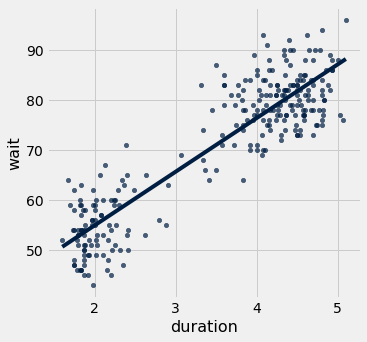

In [2]:
faithful = Table.read_table('faithful_inference.csv')
faithful.scatter('duration', fit_line=True)
faithful

Last time we looked at this dataset, we noticed the apparent linear relationship betwen duration and wait, and we decided to use regression to predict wait in terms of duration. However, our data are just a sample of all the eruptions that have happened at Old Faithful. As we know, relationships can appear in a sample that don't really exist in the population from which the sample was taken.

Before we move forward using our linear model, we would like to know whether or not there truly exists a relationship between duration and wait time. If there is no relationship between the two, then we'd expect a correlation of 0, which would give us a slope of 0. In the language of hypothesis tests, we'd like to test the following hypotheses:

- **Null Hypothesis:** The true slope of the regression line that predicts wait from duration, computed using the population of all eruptions that have ever happened, is 0. If the slope of the regression line computed from our sample isn't 0, that's just the result of chance variation.
- **Alternate Hypothesis:** The true slope of the regression line is not 0.

We will use the method of confidence intervals to test this hypothesis.

<div class="hide">\pagebreak</div>

#### Question 1
We'll warm up by implementing some familiar functions. You may use these functions throughout this assignment. Start by defining these two functions:

1. `standard_units` should take in an array of numbers and return an array containing those numbers converted to standard units.
2. `correlation` should take in a table with 2 columns and return the correlation between these columns.

In [3]:
def standard_units(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def correlation(tbl):
    return np.mean(standard_units(tbl.column(0)) * standard_units(tbl.column(1)))

<div class="hide">\pagebreak</div>

#### Question 2
Using the functions you just implemented, create a function called `fit_line`.  It should take a table as its argument.  It should return an array containing the slope and intercept of the regression line that predicts the second column in the table using the first.

In [4]:
def fit_line(tbl):
    avg_x, avg_y = np.mean(tbl.column(0)), np.mean(tbl.column(1))
    std_x, std_y = np.std(tbl.column(0)), np.std(tbl.column(1))
    slope = correlation(tbl) * std_y / std_x
    intercept = avg_y - slope * avg_x
    return make_array(slope, intercept)

fit_line(faithful)

array([10.7296414 , 33.47439702])

Now we have all the tools we need in order to create a confidence interval quantifying our uncertainty about the true relationship between duration and wait time.

<div class="hide">\pagebreak</div>

#### Question 3
Use the bootstrap to compute 1000 resamples from our dataset. For each resample, compute the slope of the best fit line. Put these slopes in the array `resample_slopes`, giving you the empirical distribution of regression line slopes in resamples.

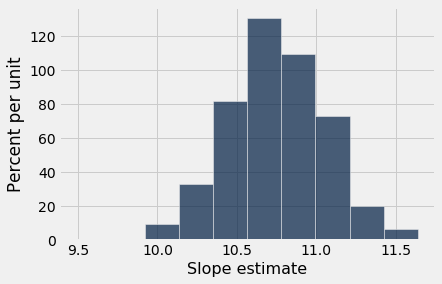

In [5]:
resample_slopes = make_array()
for i in np.arange(1000):
    sample = faithful.sample()
    resample_line = fit_line(sample)
    resample_slope = resample_line.item(0)
    resample_slopes = np.append(resample_slopes, resample_slope)

Table().with_column("Slope estimate", resample_slopes).hist()

<div class="hide">\pagebreak</div>

#### Question 4
Use your resampled slopes to construct an approximate 95% confidence interval for the true value of the slope.

In [6]:
lower_end = percentile(0.25, resample_slopes)
upper_end = percentile(97.5, resample_slopes)
print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for slope: [9.91975, 11.3489]


<div class="hide">\pagebreak</div>

#### Question 5
Based on your confidence interval, would you accept or reject the null hypothesis that the true slope is 0?  Why?  What P-value cutoff are you using?

# ============ Written Answer ===========
Since we use 95% confidence interval, we use 5% cut-off for P-value. We reject the null hypothesis since the interval doesn't contain `0`.
# ====================================

Suppose we're tourists at Yellowstone, and we'd like to know how long we'll have to wait for the next Old Faithful eruption.  We decide to use our regression line to make some predictions for the waiting times.  But just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions we'd make based on the true regression line.

<div class="hide">\pagebreak</div>

#### Question 6
Define the function `fitted_value`.  It should take 2 arguments:

1. A table with 2 columns.  We'll be predicting the values in the second column using the first.
2. A number, the value of the predictor variable for which we'd like to make a prediction.

Make sure to use your `fit_line` function. 

In [7]:
def fitted_value(table, given_x):
    # The staff solution took 4 lines of code.
    return fit_line(table).item(0) * given_x + fit_line(table).item(1)

# Here's an example of how fitted_value is used.  This should
# compute the prediction for the wait time of an eruption that lasts 
# two minutes .
two_minutes_wait = fitted_value(faithful, 2)
two_minutes_wait

54.933679813020404

<div class="hide">\pagebreak</div>

#### Question 7
The park ranger tells us that the most recent eruption lasted 5 minutes. Using your function above, assign the variable `five_minutes_wait` to the predicted wait time. 

In [8]:
five_minutes_wait = fitted_value(faithful, 5)
five_minutes_wait

87.12260399842098

Juan, a fellow tourist, raises the following objection to your prediction:

> "Your prediction depends on your sample of 272 eruptions.  Couldn't your prediction have been different if you had happened to have a different sample of eruptions?"

Having read [section 14.3](https://www.inferentialthinking.com/chapters/14/3/prediction-intervals.html) of the textbook, you know just the response!

<div class="hide">\pagebreak</div>

#### Question 8
Define the function `bootstrap_lines`.  It should take two arguments:
1. A table with two columns.  As usual, we'll be predicting the second column using the first.
2. An integer, a number of bootstraps to run.

It should return a *table* whose first column, `"Slope"`, contains the given number of bootstrapped slopes, and whose second column, `"Intercept"`, contains the corresponding bootstrapped intercepts.  Each slope and intercept should come from a regression line that predicts column 2 from column 1 of a resample of the given table.  The table should have 1 row for each bootstrap replication.

**Hint:** Your code should look very similar to the code you wrote for question 3, with just a few key changes.

In [9]:
def bootstrap_lines(tbl, num_bootstraps):
    resample_slopes = make_array()
    resample_intercepts = make_array()
    for i in np.arange(1000):
        sample = faithful.sample()
        resample_line = fit_line(sample)
        resample_slope = resample_line.item(0)
        resample_intercept = resample_line.item(1)
        resample_slopes = np.append(resample_slopes, resample_slope)
        resample_intercepts = np.append(resample_intercepts, resample_intercept)

    return Table().with_column(
        "Slope", resample_slopes,
        "Intercept", resample_intercepts)

# When you're done, this code should produce the slopes
# and intercepts of 1000 regression lines computed from
# resamples of the faithful table.
regression_lines = bootstrap_lines(faithful, 1000)
regression_lines

Slope   | Intercept
10.4034 | 35.2411
10.3206 | 34.697
11.0761 | 32.321
10.7117 | 33.7052
10.4829 | 34.1029
10.6905 | 33.2005
10.6617 | 32.7787
10.6851 | 34.252
10.3518 | 35.1137
10.8051 | 32.8651
... (990 rows omitted)

<div class="hide">\pagebreak</div>

#### Question 10
Create an array called `predictions_for_five`.  It should contain 1000 numbers.  Each number should be the predicted waiting time after an eruption with a duration of 5 minutes, using a different bootstrapped regression line.

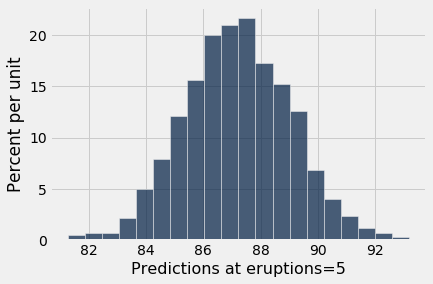

In [10]:
predictions_for_five = bootstrap_lines(faithful, 5).column(0) * 5 + bootstrap_lines(faithful, 5).column(1)

# This will make a histogram of your predictions:
table_of_predictions = Table().with_column('Predictions at eruptions=5', predictions_for_five)
table_of_predictions.hist('Predictions at eruptions=5', bins=20)

<div class="hide">\pagebreak</div>

#### Question 11
Create a 95 percent confidence interval for these predictions.

In [11]:
lower_bound = percentile(0.25, predictions_for_five)
upper_bound = percentile(97.5, predictions_for_five)

print('95% Confidence interval for predictions for x=5: (', lower_bound,",", upper_bound, ')')

95% Confidence interval for predictions for x=5: ( 81.81240123620528 , 90.88774467136076 )


<div class="hide">\pagebreak</div>

#### Question 12
Look at the scatter plot of the data at the start of this exercise.  Does your confidence interval cover around 95 percent of eruptions in `faithful` that had an eruption duration of 5 minutes? If not, what does this confidence interval mean?

# =============== Written Answer ==============
No. This confidence interval means that if we repeat the whole process of taking a sample, resampling from that sample and make prediction for an eruption duration of 5 minutes, 95% of the time (e.g. 95 out of 100 trials) our prediction for eruption duration of 5 minutes will be within the confidence interval. 

We can think of this confidence interval as the confidence interval for the mean of a population:
* It doesn't give us much information about the population
* However, it **quantifies the uncertainty** in our estimate of the true regression line's prediction

# ===========================================

## 2. Visual Diagnostics for Linear Regression


Linear regression isn't always the best way to describe the relationship between two variables. We'd like to develop techniques that will help us decide whether or not to use a linear model to predict one variable based on another.

We will use the insight that if a regression fits a set of points well, then the residuals from that regression line will show no pattern when plotted against the predictor variable. 

The table below contains information about crime rates and median home values in suburbs of Boston. We will attempt to use linear regression to predict median home value in terms of crime rate.

#### About the dataset
All data are from 1970.  Crime rates are per capita per year; home values are in thousands of dollars.  The crime data come from the FBI, and home values are from the US Census Bureau.  The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Housing).

Run the next cell to load the data and see a scatter plot.

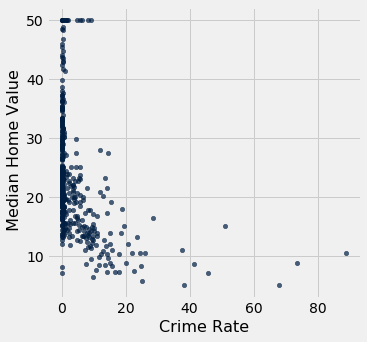

In [12]:
boston = Table.read_table('boston_housing.csv')
boston.scatter('Crime Rate')

<div class="hide">\pagebreak</div>

#### Question 1
Write a function called `residuals`.  It should take a single argument, a table.  It should first compute the slope and intercept of the regression line that predicts the second column of that table (accessible as `tbl.column(1)`) using the first column (`tbl.column(0)`).  `residuals` should return an array containing the *residuals* for that regression line. Recall that residuals are given by 

$$\texttt{residual} = \texttt{observed value} - \texttt{regression estimate}.$$

In [13]:
boston

Crime Rate |  Median Home Value
0.00632    | 24
0.02731    | 21.6
0.02729    | 34.7
0.03237    | 33.4
0.06905    | 36.2
0.02985    | 28.7
0.08829    | 22.9
0.14455    | 27.1
0.21124    | 16.5
0.17004    | 18.9
... (496 rows omitted)

In [14]:
def residuals(tbl):
    mean_x, mean_y = np.mean(tbl.column(0)), np.mean(tbl.column(1))
    sd_x, sd_y = np.std(tbl.column(0)), np.std(tbl.column(1))
    # Below is x and y in standard units
    su_x, su_y = (tbl.column(0) - mean_x) / sd_x, (tbl.column(1) - mean_y) / sd_y
    r = np.mean(su_x * su_y)
    slope = r * sd_y / sd_x
    intercept = mean_y - slope * mean_x
    regression_estimate = tbl.column(0) * slope + intercept
    return tbl.column(1) - regression_estimate

<div class="hide">\pagebreak</div>

#### Question 2
Make a scatter plot of the residuals for the Boston housing dataset against crime rate. Crime rate should be on the horizontal axis.

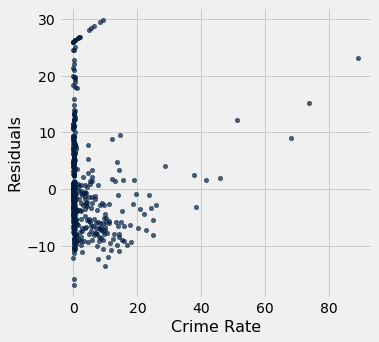

In [15]:
boston.with_column('Residuals', residuals(boston)).drop(1).scatter(0)

<div class="hide">\pagebreak</div>

#### Question 3
Does the plot of residuals look roughly like a formless cloud?  Or is there some kind of pattern in them?

# ================= Written Answer =============
No. 

1. For homes with very low crime rate, the residuals appear to be scattered all over the place.
2. For homes with very high crime rate, the residual appear to be relatively high
3. There's a somewhat scarce linear relationship for homes with intermediate crimerate

# ===========================================

<div class="hide">\pagebreak</div>

#### Question 4
Does it seem like a linear model is appropriate for describing the relationship between crime and median home value? Explain your reasoning.

# ================= Written Answer ===============
No. The plot of residuals don't resemble a formless cloud, which suggests that the linear model is not a good fit.
# =============================================

[Section 13.6](https://www.inferentialthinking.com/chapters/13/6/numerical-diagnostics.html) of the textbook describes some mathematical facts that hold for all regression estimates, regardless of goodness of fit.  One fact is that there is a relationship between the standard deviation of the residuals, the standard deviation of the response variable, and the correlation.  Let us test this.

Below, we have imported a new table, the Old Faithful data.

In [16]:
old_faithful = Table.read_table('faithful.csv')
old_faithful

duration | wait
3.6      | 79
1.8      | 54
3.333    | 74
2.283    | 62
4.533    | 85
2.883    | 55
4.7      | 88
3.6      | 85
1.95     | 51
4.35     | 85
... (262 rows omitted)

The following cell makes a residual plot for this new dataset.

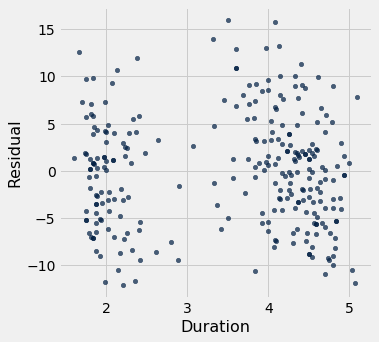

In [17]:
Table().with_columns('Residual', residuals(old_faithful), 'Duration', faithful.column('duration')).scatter('Duration')

<div class="hide">\pagebreak</div>

#### Question 5
Directly compute the standard deviation of the residuals from the Boston data.  Then compute the same quantity without using the residuals, using the formula described in section 13.6 instead.

In [18]:
boston_residual_sd = np.std(residuals(boston))
boston_residual_sd_from_formula = ((1 - (correlation(boston))**2)**0.5) * np.std(boston.column(1))

print("Residual SD: {0}".format(boston_residual_sd))
print("Residual SD from the formula: {0}".format(boston_residual_sd_from_formula))

Residual SD: 8.474144781120948
Residual SD from the formula: 8.474144781120948


<div class="hide">\pagebreak</div>

#### Question 6
Repeat the procedure from Question 5 for the `old_faithful` dataset.

In [19]:
faithful_residual_sd = np.std(residuals(old_faithful))
faithful_residual_sd_from_formula = ((1 - (correlation(old_faithful))**2)**0.5) * np.std(old_faithful.column(1))

print("Residual SD: {0}".format(faithful_residual_sd))
print("Residual SD from the formula: {0}".format(faithful_residual_sd_from_formula))

Residual SD: 5.892226635893954
Residual SD from the formula: 5.892226635893948


## 3. Better Ice Cream Sales through Minimization


In this exercise, we'll use `minimize` to find an optimal location for an ice cream truck.  Minimization is useful in a vast array of applications - it's not just for finding the best line through a scatter plot!

You'll see 3 different ways to do minimization:
1. Using a slider to find the best location manually
2. Trying a bunch of locations using `apply` and finding the best one using `sort`
3. Using `minimize`

Data 8 is poised to disrupt the ice cream market.  We're catering to San Francisco hipsters, so we operate a truck that sells our locally-sourced organic Sriracha-Kale ice cream.  Today we have driven our truck to Ocean Beach, a long, narrow beach on the western coast of the city.

<img src="ocean_beach.jpg">

Upon arriving, we find that our potential customers are spread out along the beach.  We decide we want to park our truck in the location that's closest *on average* to all the customers.  That way, customers will be more likely to come to our truck.

(This may not be a great way to choose our truck's location.  Maybe you can think of a better way to decide on a location.)

We canvas the beach and record the location of each beachgoer in a table called `customers`.  The beach is oriented roughly North/South, and it's narrow, so we ignore how close each beachgoer is to the water.  We record only how far north each person is from the southern end of the beach.

Suppose there are 2 people on the beach, at 600 meters and 950 meters from the Southern end, respectively.  If we park our truck at 750 meters, the average distance from our truck to customers is:

$$\frac{|600 - 750| + |950 - 750|}{2}.$$



<img src="beach_locations.jpg">

By now, the Python code that computes this might look a little familiar:

In [20]:
# The customer locations:
two_customer_locations = make_array(600, 950)

first_truck_location = 750

two_customers_mean_distance_from_750 = np.mean(np.abs(two_customer_locations - first_truck_location))
two_customers_mean_distance_from_750

175.0

<div class="hide">\pagebreak</div>

#### Question 1
A new person shows up on the beach, so the new customer locations are 600, 950, and 1,150 meters from the southern end.  If we park our ice cream truck at the *mean* of those locations, what is the average distance from our truck to customers?

In [21]:
three_customer_locations = make_array(600, 950, 1150)

mean = np.mean(three_customer_locations)
n = len(three_customer_locations) # n is number of customers
sum_of_distances = sum(abs(three_customer_locations - mean))

# Compute this.
three_customers_mean_distance_from_mean = sum_of_distances / n
three_customers_mean_distance_from_mean

200.0

In [22]:
_ = tests.grade('q3_1')

NameError: name 'tests' is not defined

<div class="hide">\pagebreak</div>

#### Question 2
The mean is 900 meters.  If we park our truck at 925 meters instead, what's the average distance from our truck to a customer?

In [23]:
# Fill in three_customers_mean_distance_from_925.  Use code to compute it.
three_customers_mean_distance_from_925 = sum(abs(three_customer_locations - 925)) / n
three_customers_mean_distance_from_925

191.66666666666666

In [24]:
_ = tests.grade('q3_2')

NameError: name 'tests' is not defined

The average distance went down!  Despite what your intuition might say, the mean of the customer locations isn't the best location to pick.

Use the slider created by the next cell to find approximately the best location for the `three_customer_locations` dataset.  (You'll only be able to get within 5 of the best location.  It's okay if your submission doesn't display the slider.)

In [25]:
def three_customers_distance(location):
    return np.mean(np.abs(three_customer_locations - location))

interact(three_customers_distance, location=widgets.FloatSlider(min=700, max=1300, step=5, value=900, msg_throttle=1));

interactive(children=(FloatSlider(value=900.0, description='location', max=1300.0, min=700.0, step=5.0), Outpu…

<div class="hide">\pagebreak</div>

#### Question 3
What location did you find?  What was the average distance to customers from that location?  Is that location around the same as any familiar statistic of the data?

# ============== Written Answer =============
The location `950` meter appears to be the best location. `950` meter returns an average distance to customers of `183.33` meter. This location happens to be the median of the locations of the 3 customers.
# ========================================

#### The full dataset
Now let's look at the full customer dataset.  In this dataset, there are 1,000 people on the beach.  The next cell displays a histogram of their locations.

Distance from south end (m)
935
1055
1975
521
1786
869
864
1789
975
1780
... (990 rows omitted)

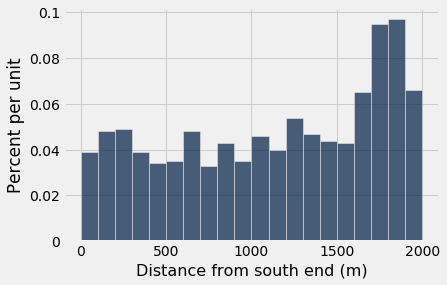

In [26]:
# Just run this cell.
customers = Table.read_table("customers.csv")
customers.hist(bins=np.arange(0, 2001, 100))
customers

Let's think very precisely about what we're trying to optimize.  Given these customer locations, we want to find a *single location*.  If we park our truck at that location, we want it to result in the smallest *average distance from our truck to customers*.

<div class="hide">\pagebreak</div>

#### Question 4
Write a function called `average_distance`.  It should take a single number as its argument (a truck location) and return the average distance from that location to the customers in the `customers` table.

In [27]:
def average_distance(location):
    # Fill in the function definition here.
    n = customers.num_rows
    sum_abs = sum(abs(customers.column(0) - location))
    return sum_abs / n

# An example call to your function:
average_distance(1000)

547.346

In [28]:
_ = tests.grade('q3_4')

NameError: name 'tests' is not defined

`average_distance` tells us how badly we're meeting our objective.  A mathematician would call this an *objective function*.  We want to find the distance that produces the smallest value of this objective function.

Use the slider created by the next cell to find approximately the best location for the `customers` dataset. (You'll only be able to get within 5 of the best location.)

In [29]:
interact(average_distance, location=widgets.FloatSlider(min=700, max=1300, step=5, value=800, msg_throttle=1));

interactive(children=(FloatSlider(value=800.0, description='location', max=1300.0, min=700.0, step=5.0), Outpu…

<div class="hide">\pagebreak</div>

#### Question 5
What location did you find, and what was the average distance to customers from that location?

# ============ Written Answer ==========
`1,215` meters appear to be the best location. The average distance resulted was `525.426` meters.

# ===================================

<div class="hide">\pagebreak</div>

#### Question 6
Create a table called `average_distances` with two columns:

1. `"location"`, a truck location.  The smallest location should be 700 and the largest should be 1300, and they should go up in increments of 1.
2. `"average distance to customers"`.  The average distance from customers (in the `customers` table) to that location.

**Then**, sort the table to find the location with the smallest average distance to customers.  Name the sorted table `sorted_average_distances`, and name the best location (a number) `best_location_by_sorting`.

**Hint:** The staff solution used the table method `apply`.  If you don't, you'll need to use a `for` loop, and your code will be longer than the skeleton suggests.

In [30]:
locations = Table().with_column("location", np.arange(700, 1300+1, 1))

average_distances = locations.with_column("average distance to customers", locations.apply(average_distance, 0))

sorted_average_distances = average_distances.sort(1)
sorted_average_distances.show(5)

best_location_by_sorting = sorted_average_distances.column(0).item(0)
best_location_by_sorting

1216

The function `minimize` does basically the same thing you just did.

It takes as its argument a *function*, the objective function.  It returns the input (that is, the argument) that produces the smallest output value of the objective function.  If the objective function takes several arguments, it returns the arguments that produce the smallest output value of the objective function, all together in one array.

<div class="hide">\pagebreak</div>

#### Question 7
Use `minimize` to find the best location for our ice cream truck.

In [31]:
# Write code to compute the best location, using minimize.
best_location = minimize(average_distance)
best_location

1215.9946756015574

Your answer should match `best_location_by_sorting` up to a few decimal places.

Later in the day, the distribution of potential customers along the beach has changed.  `customers2.csv` contains their new locations.

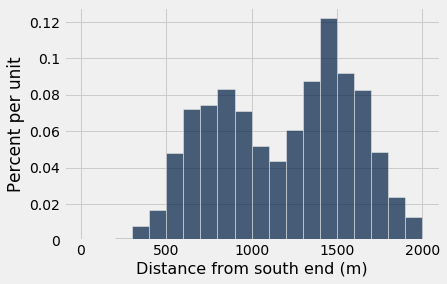

In [32]:
customers2 = Table.read_table('customers2.csv')
customers2.hist(bins=np.arange(0, 2000+100, 100))

<div class="hide">\pagebreak</div>

#### Question 8
Find the new best location for our ice cream truck.

In [33]:
customers2

Distance from south end (m)
883.277
619.053
634.417
617.779
654.781
1120.19
549.431
945.256
785.69
808.331
... (4490 rows omitted)

In [35]:
# Hint: The staff solution defined a function called average_distance2.
# We recommend doing that.
def average_distance2(location):
    n = customers2.num_rows
    sum_abs = sum(abs(customers2.column(0) - location))
    return sum_abs / n
    

new_best_location = minimize(average_distance2)
new_best_location

1248.6611331546003

If you'd like to check your answer, try doing what you did in question 6.  Your answer to question 3 may also be useful.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [tests.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")